# INFO 3402 – Class 24: Grouping and Aggregating Data

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)  

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd

pd.options.display.max_columns = 200

Groupby-aggregation is an *extremely* common and ***very*** powerful mechanism for summarizing data. Where we had combined different datasets together using joins and merges to add in additional (typically) columns, groupby-aggregation refers to summarizing (typically) rows of data.

Groupby-aggregation, as the name suggests, involves a sequence of different steps:

* **First**, grouping similar data together when they share a common value/identifier. Examples include schools within the same district, events on the same date, or actions taken by the same account.  
* **Second**, applying some function to each group independently to summarize the statistics about that group.
* **Third**, combining the results from each group back into a data structure comparing results across all groups.

Typically the second and third steps above are combined into an "aggregation" step. This figure summarizes the steps:

![split-apply-combine](https://jakevdp.github.io/PythonDataScienceHandbook/figures/03.08-split-apply-combine.png)

## Data

The State of Colorado publishes a variety of data about schools throughout the state:

* Membership by grade level, free and reduced lunch, ethnicity/gender: [Pupil Membership](https://www.cde.state.co.us/cdereval/pupilcurrentschool)
* [Immunization data](https://www.cohealthdata.dphe.state.co.us/Data/Details/1)
* [State assessments](http://cashew.cde.state.co.us/cognos/cgi-bin/cognos.cgi?b_action=cognosViewer&ui.action=run&ui.object=%2fcontent%2ffolder%5b%40name%3d%27State%20Assessment%20Data%20Lab%27%5d%2freport%5b%40name%3d%27State%20Assessment%20Data%20Lab%27%5d&ui.name=State%20Assessment%20Data%20Lab&run.outputFormat=&run.prompt=true&ui.backURL=%2fcognos%2fcgi-bin%2fcognos.cgi%3fb_action%3dxts.run%26m%3dportal%2fcc.xts%26m_folder%3diD5FCA1A24B834757B6D74BC08BE8AF1D)

These data have the common pattern of there being multiple schools within a single district. The goal we will explore is how to summarize school-level statistics into district-level aggregated statistics. We will draw on previous modules' lessons about exploring, cleaning, and combining data.

Start by loading the data about school-level immunizations (for 2016–2017). There is data about:
* enrollments;
* summary statistics about exemptions, in process, incomplete, and no records; 
* vaccine-specific statistics for Hepatitis B, DTAP, polio, MMR, varicella, and TDAP  
  * up-to-date, medical exemptions, religious exemptions, personal exemptions, in-process, McKinny-Vento (homelessness), incomplete, no records
  
Our goal is to perform an exploratory data analysis around the factors that contribute to [vaccine hesitancy](https://en.wikipedia.org/wiki/Vaccine_hesitancy) in Colorado, the state with the [lowest rate of childhood vaccinations in the country](https://www.cdc.gov/mmwr/volumes/67/wr/mm6740a3.htm?s_cid=mm6740a3_w) and [strong political resistance to eliminating personal exemptions](https://coloradosun.com/2019/02/21/colorado-vaccination-rate-lowest-fix-jared-polis/) to vaccination requirements.

In [3]:
# Read in file
immunizations_df = pd.read_excel('./Schools/immunization_schools.xlsx')

# Identify "good" column names and skip columns that have "Unnamed: " in them
immunization_good_cols = [col for col in immunizations_df.columns if 'Unnamed: ' not in col]

# Reshape the DataFrame to keep the columns in immunization_good_cols
immunizations_df = immunizations_df[immunization_good_cols]

# Clean up some of the values and columns
immunizations_df.replace({'School Type':{'HIGH':'High'}},inplace=True)

immunizations_df.rename(columns={'School District Label':'School District',
                                 'Total Enrollment (Includes 6-12 Grade Enrollment)':'Total Enrollment',
                                 '6-12 Grade Enrollment (Tdap Eligible)':'6-12 Grade Enrollment'}
                        ,inplace=True)

immunizations_df['School Name'] = immunizations_df['School Name'].str.upper()

# Inspect
immunizations_df.head()

,Facility Type,School Type,School District,School Name,Address,6-12 Grade Enrollment,Total Enrollment,Average Up to Date Rate,Average Exemption Rate,Average In Process Rate,Average Incomplete Record Rate,Average No Record Rate,HepB: Up to Date Rate,HepB: Medical Exemptions Rate,HepB: Religious Exemptions Rate,HepB: Personal Exemptions Rate,HepB: In Process Rate,HepB: McKinny-Vento Exemptions Rate,HepB: Incomplete Record Rate,HepB: No Record Rate,Dtap: Up to Date Rate,Dtap: Medical Exemptions Rate,Dtap: Religious Exemptions Rate,Dtap: Personal Exemptions Rate,Dtap: In Process Rate,Dtap: McKinny-Vento Exemptions Rate,Dtap: Incomplete Record Rate,Dtap: No Record Rate,Polio: Up to Date Rate,Polio: Medical Exemptions Rate,Polio: Religious Exemptions Rate,Polio: Personal Exemptions Rate,Polio: In Process Rate,Polio: McKinny-Vento Exemptions Rate,Polio: Incomplete Record Rate,Polio: No Record Rate,MMR: Up to Date Rate,MMR: Medical Exemptions Rate,MMR: Religious Exemptions Rate,MMR: Personal Exemptions Rate,MMR: In Process Rate,MMR: McKinny-Vento Exemptions Rate,MMR: Incomplete Record Rate,MMR: No Record Rate,Varicella: Up to Date Rate,Varicella: Medical Exemptions Rate,Varicella: Religious Exemptions Rate,Varicella: Personal Exemptions Rate,Varicella: In Process Rate,Varicella: McKinny-Vento Exemptions Rate,Varicella: Incomplete Record Rate,Varicella: No Record Rate,Tdap: Up to Date,Tdap: Medical Exemptions,Tdap: Religious Exemptions,Tdap: Personal Exemptions,Tdap: In Process,Tdap: McKinny-Vento Exemptions,Tdap: Incomplete Record,Tdap: No Record
0,PUBLIC,Middle/High,PUEBLO COUNTY 70,70 ONLINE,"301 LANE 28 PUEBLO, CO 81001",165.0,168.0,0.9413,0.0209,0.0139,0.0239,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.8929,0.0000,0.0000,0.0238,0.0595,0.0,0.0238,0.0000,0.9212,0.0,0.0000,0.0303,0.0242,0.0,0.0242,0.000
1,PUBLIC,High,DENVER COUNTY 1,ABRAHAM LINCOLN HIGH SCHOOL,"2285 SOUTH FEDERAL BOULEVARD DENVER, CO 80219",1145.0,1145.0,0.9271,0.0048,0.0016,0.0242,0.0424,0.9301,0.0009,0.0009,0.0026,0.0009,0.0,0.0419,0.0227,0.9310,0.0000,0.0009,0.0026,0.0009,0.0,0.0087,0.0559,0.9493,0.0000,0.0009,0.0026,0.0026,0.0,0.0253,0.0192,0.9389,0.0000,0.0009,0.0026,0.0009,0.0,0.0349,0.0218,0.8655,0.0044,0.0017,0.0035,0.0044,0.0,0.0341,0.0865,0.9476,0.0,0.0017,0.0026,0.0000,0.0,0.0000,0.048
2,PUBLIC,Elementary,FOUNTAIN 8,ABRAMS ELEMENTARY SCHOOL,"600 CHILES AVENUE FORT CARSON, CO 80902",0.0,477.0,0.9052,0.0130,0.0000,0.0629,0.0189,0.9329,0.0042,0.0000,0.0126,0.0000,0.0,0.0314,0.0189,0.9245,0.0021,0.0000,0.0084,0.0000,0.0,0.0461,0.0189,0.9078,0.0042,0.0000,0.0084,0.0000,0.0,0.0608,0.0189,0.8805,0.0021,0.0000,0.0105,0.0000,0.0,0.0881,0.0189,0.8805,0.0021,0.0000,0.0105,0.0000,0.0,0.0881,0.0189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC,Elementary,DENVER COUNTY 1,ACADEMIA ANA MARIE SANDOVAL,"3655 WYANDOT STREET DENVER, CO 80211",0.0,295.0,0.8854,0.0393,0.0061,0.0210,0.0475,0.8576,0.0000,0.0034,0.0407,0.0034,0.0,0.0475,0.0475,0.8780,0.0000,0.0034,0.0339,0.0237,0.0,0.0102,0.0475,0.8983,0.0000,0.0034,0.0407,0.0034,0.0,0.0068,0.0475,0.9017,0.0000,0.0034,0.0305,0.0000,0.0,0.0169,0.0475,0.8915,0.0000,0.0034,0.0339,0.0000,0.0,0.0237,0.0475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PUBLIC,Elementary,DENVER COUNTY 1,ACADEMY 360,"12505 ELMENDORF PL DENVER, CO 80239",0.0,166.0,0.8867,0.0084,0.0000,0.0627,0.0422,0.8795,0.0000,0.0000,0.0000,0.0000,0.0,0.0783,0.0422,0.8795,0.0060,0.0000,0.0060,0.0000,0.0,0.0663,0.0422,0.8855,0.0060,0.0000,0.0060,0.0000,0.0,0.0602,0.0422,0.8916,0.0060,0.0000,0.0060,0.0000,0.0,0.0542,0.0422,0.8976,0.0000,0.0000,0.0060,0.0000,0.0,0.0542,0.0422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are a number of rows with repeated values. We can group these rows of data together to perform aggregations on them in the future.

In [4]:
immunizations_df['Facility Type'].value_counts()

PUBLIC     1781
PRIVATE     304
Name: Facility Type, dtype: int64

In [5]:
immunizations_df['School Type'].value_counts()

Elementary     845
High           280
Middle         263
Elem/Middle    130
PRIVATE        128
K-12            80
Middle/High     75
Name: School Type, dtype: int64

In [6]:
immunizations_df['School District'].value_counts().head(10)

DENVER COUNTY 1               225
JEFFERSON COUNTY R-1          173
DOUGLAS COUNTY RE 1            93
CHERRY CREEK 5                 71
BOULDER VALLEY RE 2            66
COLORADO SPRINGS 11            65
ADAMS-ARAPAHOE 28J             59
POUDRE R-1                     58
ST VRAIN VALLEY RE 1J          56
ADAMS 12 FIVE STAR SCHOOLS     55
Name: School District, dtype: int64

## Intuition

What is the average enrollment of each "School Type"? In other words, how many students do high schools, middle schools, elementary schools, *etc*. enroll on average?

A simple way to approach this would be to:

* **Splitting**: use boolean indexing make "baby DataFrames" for each different value of "School Type"
* **Applying**: take the average of the "Total Enrollment" column in each baby DataFrame (each type of school)
* **Combining**: combine the results of the average enrollment for each type of school back into a DataFrame

In [7]:
# Make a single baby DataFrame for high schools
high_school_immunizations_df = immunizations_df[immunizations_df['School Type'] == 'High']

high_school_immunizations_df.head()

,Facility Type,School Type,School District,School Name,Address,6-12 Grade Enrollment,Total Enrollment,Average Up to Date Rate,Average Exemption Rate,Average In Process Rate,Average Incomplete Record Rate,Average No Record Rate,HepB: Up to Date Rate,HepB: Medical Exemptions Rate,HepB: Religious Exemptions Rate,HepB: Personal Exemptions Rate,HepB: In Process Rate,HepB: McKinny-Vento Exemptions Rate,HepB: Incomplete Record Rate,HepB: No Record Rate,Dtap: Up to Date Rate,Dtap: Medical Exemptions Rate,Dtap: Religious Exemptions Rate,Dtap: Personal Exemptions Rate,Dtap: In Process Rate,Dtap: McKinny-Vento Exemptions Rate,Dtap: Incomplete Record Rate,Dtap: No Record Rate,Polio: Up to Date Rate,Polio: Medical Exemptions Rate,Polio: Religious Exemptions Rate,Polio: Personal Exemptions Rate,Polio: In Process Rate,Polio: McKinny-Vento Exemptions Rate,Polio: Incomplete Record Rate,Polio: No Record Rate,MMR: Up to Date Rate,MMR: Medical Exemptions Rate,MMR: Religious Exemptions Rate,MMR: Personal Exemptions Rate,MMR: In Process Rate,MMR: McKinny-Vento Exemptions Rate,MMR: Incomplete Record Rate,MMR: No Record Rate,Varicella: Up to Date Rate,Varicella: Medical Exemptions Rate,Varicella: Religious Exemptions Rate,Varicella: Personal Exemptions Rate,Varicella: In Process Rate,Varicella: McKinny-Vento Exemptions Rate,Varicella: Incomplete Record Rate,Varicella: No Record Rate,Tdap: Up to Date,Tdap: Medical Exemptions,Tdap: Religious Exemptions,Tdap: Personal Exemptions,Tdap: In Process,Tdap: McKinny-Vento Exemptions,Tdap: Incomplete Record,Tdap: No Record
1,PUBLIC,High,DENVER COUNTY 1,ABRAHAM LINCOLN HIGH SCHOOL,"2285 SOUTH FEDERAL BOULEVARD DENVER, CO 80219",1145.0,1145.0,0.9271,0.0048,0.0016,0.0242,0.0424,0.9301,0.0009,0.0009,0.0026,0.0009,0.0,0.0419,0.0227,0.9310,0.0,0.0009,0.0026,0.0009,0.0,0.0087,0.0559,0.9493,0.0,0.0009,0.0026,0.0026,0.0,0.0253,0.0192,0.9389,0.0000,0.0009,0.0026,0.0009,0.0,0.0349,0.0218,0.8655,0.0044,0.0017,0.0035,0.0044,0.0,0.0341,0.0865,0.9476,0.0,0.0017,0.0026,0.0000,0.0,0.0000,0.048
8,PUBLIC,High,MAPLETON 1,ACADEMY HIGH SCHOOL,"8970 YORK STREET THORNTON, CO 80229",435.0,435.0,0.9414,0.0019,0.0004,0.0333,0.0230,0.9586,0.0000,0.0000,0.0000,0.0000,0.0,0.0184,0.0230,0.9655,0.0,0.0000,0.0000,0.0000,0.0,0.0115,0.0230,0.9057,0.0,0.0000,0.0000,0.0023,0.0,0.0690,0.0230,0.9609,0.0023,0.0000,0.0023,0.0000,0.0,0.0115,0.0230,0.9011,0.0000,0.0000,0.0046,0.0000,0.0,0.0713,0.0230,0.9563,0.0,0.0000,0.0023,0.0000,0.0,0.0184,0.023
11,PUBLIC,High,DENVER COUNTY 1,ACADEMY OF URBAN LEARNING,"2417 W. 29TH AVE DENVER, CO 80211",104.0,104.0,0.9599,0.0096,0.0000,0.0304,0.0000,0.9712,0.0000,0.0000,0.0096,0.0000,0.0,0.0192,0.0000,0.9808,0.0,0.0000,0.0096,0.0000,0.0,0.0096,0.0000,0.9808,0.0,0.0000,0.0096,0.0000,0.0,0.0096,0.0000,0.9615,0.0096,0.0000,0.0096,0.0000,0.0,0.0192,0.0000,0.9038,0.0000,0.0000,0.0000,0.0000,0.0,0.0962,0.0000,0.9615,0.0,0.0000,0.0096,0.0000,0.0,0.0288,0.000
12,PUBLIC,High,ACADEMY 20,ACADEMY ONLINE HIGH SCHOOL,"1110 CHAPEL HILLS DRIVE COLORADO SPRINGS, CO 8...",88.0,88.0,0.8580,0.0606,0.0000,0.0682,0.0000,0.8977,0.0000,0.0114,0.0455,0.0000,0.0,0.0455,0.0000,0.9432,0.0,0.0114,0.0341,0.0000,0.0,0.0114,0.0000,0.8523,0.0,0.0000,0.0568,0.0000,0.0,0.0114,0.0000,0.9205,0.0000,0.0114,0.0455,0.0000,0.0,0.0227,0.0000,0.6818,0.0568,0.0114,0.0341,0.0000,0.0,0.2159,0.0000,0.8523,0.0,0.0114,0.0341,0.0000,0.0,0.1023,0.000
17,PUBLIC,High,ADAMS COUNTY 14,ADAMS CITY HIGH SCHOOL,"7200 QUEBEC PARKWAY COMMERCE CITY, CO 80022",1793.0,1793.0,0.9879,0.0011,0.0112,0.0000,0.0000,0.9833,0.0000,0.0011,0.0000,0.0156,0.0,0.0000,0.0000,1.0000,0.0,0.0011,0.0000,0.0000,0.0,0.0000,0.0000,0.9955,0.0,0.0011,0.0000,0.0033,0.0,0.0000,0.0000,0.9922,0.0000,0.0011,0.0000,0.0067,0.0,0.0000,0.0000,0.9665,0.0000,0.0011,0.0000,0.0323,0.0,0.0000,0.0000,0.9900,0.0,0.0011,0.0000,0.0089,0.0,0.0000,0.000


In [8]:
high_school_immunizations_df['School Type'].value_counts()

High    280
Name: School Type, dtype: int64

Then we could take the average of "Total Enrollment" column.

In [9]:
high_school_immunizations_df["Total Enrollment"].mean()

790.9535714285714

Now do this for each of the types of schools.

In [10]:
school_types = ['Elementary', 'High', 'Middle', 'Elem/Middle', 'PRIVATE', 'K-12', 'Middle/High']

# An empty dictionary to store the averages
school_type_averages_d = {}

for school_type in school_types:
    # Splitting
    baby_dataframe = immunizations_df[immunizations_df['School Type'] == school_type]
    
    # Applying
    enrollment_mean = baby_dataframe["Total Enrollment"].mean()
    
    # Combining
    school_type_averages_d[school_type] = enrollment_mean
    
# Turn the dictionary into a pandas Series, sort the index so it matches the next example
pd.Series(school_type_averages_d).sort_index()


Elem/Middle    526.938462
Elementary     395.920710
High           790.953571
K-12           490.762500
Middle         546.790875
Middle/High    368.866667
PRIVATE        225.367188
dtype: float64

That involved a lot of steps—remember that programmers are, first and foremost, lazy! The brilliance of groupby-aggregation is we can accomplish the same thing in a single line, which both saves us time and reduces the chances of errors!

In [11]:
immunizations_df.groupby('School Type').agg({'Total Enrollment':'mean'})

,Total Enrollment
School Type,
Elem/Middle,526.938462
Elementary,395.920710
High,790.953571
K-12,490.762500
Middle,546.790875
Middle/High,368.866667
PRIVATE,225.367188


## Splitting with `groupby`

We will decompose a group-aggregation into its respective parts, starting with the [`.groupby`](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.groupby.html) operation that splits the data. The most important concept you need to internalize is that when you do a `groupby` you are making a "baby DataFrame" where the rows of that DataFrame have something all in common: whatever value you grouped on. 

You saw above how we used Boolean indexing to make a baby DataFrame for only high schools. I will show two other ways that groupbys create "baby DataFrames" that share some value in common.

***ULTRA IMPORTANT NOTE***: 99.999% of the time you will not be using any of these functions because you're going to `aggregate` the data together in combination with `groupby`. This section is simply to show you what is happening under the hood when you perform a `groupby`: you are making baby DataFrames that share some value in common.

Create a `immunizations_gb_school_type` that stores the results of grouping `immunizations_df` by "School Type".

In [12]:
immunizations_gb_school_type = immunizations_df.groupby('School Type')

In [13]:
immunizations_gb_school_type

What is a GroupBy object? Basically a dictionary with the keys as the groupby values and the values are a list of the rows of data where those values live. You can see this with the `.groups` object.

In [14]:
immunizations_gb_school_type.groups

{'Elem/Middle': Int64Index([   5,    6,   15,   38,   58,   62,   63,   68,   70,   73,
             ...
             1632, 1652, 1671, 1677, 1735, 1753, 1761, 1772, 1785, 1788],
            dtype='int64', length=130),
 'Elementary': Int64Index([   2,    3,    4,    7,    9,   16,   19,   20,   22,   27,
             ...
             1774, 1775, 1776, 1780, 1782, 1783, 1786, 1789, 1795, 1799],
            dtype='int64', length=845),
 'High': Int64Index([   1,    8,   11,   12,   17,   24,   28,   41,   47,   49,
             ...
             1749, 1755, 1762, 1769, 1777, 1790, 1792, 1793, 1798, 1800],
            dtype='int64', length=280),
 'K-12': Int64Index([  10,   21,   23,   25,   45,  127,  204,  239,  258,  261,  273,
              289,  298,  302,  323,  352,  360,  361,  387,  410,  473,  511,
              540,  592,  610,  611,  615,  616,  625,  638,  653,  727,  728,
              731,  834,  848,  854,  863,  909,  915,  941,  953,  963, 1083,
             1093, 1100, 11

We can test to see if these rows of data are indeed all "Elementary" schools.

In [15]:
high_school_rows = immunizations_gb_school_type.groups['High']
high_school_rows

Int64Index([   1,    8,   11,   12,   17,   24,   28,   41,   47,   49,
            ...
            1749, 1755, 1762, 1769, 1777, 1790, 1792, 1793, 1798, 1800],
           dtype='int64', length=280)

Access these rows of data from the parent `immunization_df` DataFrame. Sure enough, these are all elementary schools.

In [16]:
immunizations_df.loc[high_school_rows].head()

,Facility Type,School Type,School District,School Name,Address,6-12 Grade Enrollment,Total Enrollment,Average Up to Date Rate,Average Exemption Rate,Average In Process Rate,Average Incomplete Record Rate,Average No Record Rate,HepB: Up to Date Rate,HepB: Medical Exemptions Rate,HepB: Religious Exemptions Rate,HepB: Personal Exemptions Rate,HepB: In Process Rate,HepB: McKinny-Vento Exemptions Rate,HepB: Incomplete Record Rate,HepB: No Record Rate,Dtap: Up to Date Rate,Dtap: Medical Exemptions Rate,Dtap: Religious Exemptions Rate,Dtap: Personal Exemptions Rate,Dtap: In Process Rate,Dtap: McKinny-Vento Exemptions Rate,Dtap: Incomplete Record Rate,Dtap: No Record Rate,Polio: Up to Date Rate,Polio: Medical Exemptions Rate,Polio: Religious Exemptions Rate,Polio: Personal Exemptions Rate,Polio: In Process Rate,Polio: McKinny-Vento Exemptions Rate,Polio: Incomplete Record Rate,Polio: No Record Rate,MMR: Up to Date Rate,MMR: Medical Exemptions Rate,MMR: Religious Exemptions Rate,MMR: Personal Exemptions Rate,MMR: In Process Rate,MMR: McKinny-Vento Exemptions Rate,MMR: Incomplete Record Rate,MMR: No Record Rate,Varicella: Up to Date Rate,Varicella: Medical Exemptions Rate,Varicella: Religious Exemptions Rate,Varicella: Personal Exemptions Rate,Varicella: In Process Rate,Varicella: McKinny-Vento Exemptions Rate,Varicella: Incomplete Record Rate,Varicella: No Record Rate,Tdap: Up to Date,Tdap: Medical Exemptions,Tdap: Religious Exemptions,Tdap: Personal Exemptions,Tdap: In Process,Tdap: McKinny-Vento Exemptions,Tdap: Incomplete Record,Tdap: No Record
1,PUBLIC,High,DENVER COUNTY 1,ABRAHAM LINCOLN HIGH SCHOOL,"2285 SOUTH FEDERAL BOULEVARD DENVER, CO 80219",1145.0,1145.0,0.9271,0.0048,0.0016,0.0242,0.0424,0.9301,0.0009,0.0009,0.0026,0.0009,0.0,0.0419,0.0227,0.9310,0.0,0.0009,0.0026,0.0009,0.0,0.0087,0.0559,0.9493,0.0,0.0009,0.0026,0.0026,0.0,0.0253,0.0192,0.9389,0.0000,0.0009,0.0026,0.0009,0.0,0.0349,0.0218,0.8655,0.0044,0.0017,0.0035,0.0044,0.0,0.0341,0.0865,0.9476,0.0,0.0017,0.0026,0.0000,0.0,0.0000,0.048
8,PUBLIC,High,MAPLETON 1,ACADEMY HIGH SCHOOL,"8970 YORK STREET THORNTON, CO 80229",435.0,435.0,0.9414,0.0019,0.0004,0.0333,0.0230,0.9586,0.0000,0.0000,0.0000,0.0000,0.0,0.0184,0.0230,0.9655,0.0,0.0000,0.0000,0.0000,0.0,0.0115,0.0230,0.9057,0.0,0.0000,0.0000,0.0023,0.0,0.0690,0.0230,0.9609,0.0023,0.0000,0.0023,0.0000,0.0,0.0115,0.0230,0.9011,0.0000,0.0000,0.0046,0.0000,0.0,0.0713,0.0230,0.9563,0.0,0.0000,0.0023,0.0000,0.0,0.0184,0.023
11,PUBLIC,High,DENVER COUNTY 1,ACADEMY OF URBAN LEARNING,"2417 W. 29TH AVE DENVER, CO 80211",104.0,104.0,0.9599,0.0096,0.0000,0.0304,0.0000,0.9712,0.0000,0.0000,0.0096,0.0000,0.0,0.0192,0.0000,0.9808,0.0,0.0000,0.0096,0.0000,0.0,0.0096,0.0000,0.9808,0.0,0.0000,0.0096,0.0000,0.0,0.0096,0.0000,0.9615,0.0096,0.0000,0.0096,0.0000,0.0,0.0192,0.0000,0.9038,0.0000,0.0000,0.0000,0.0000,0.0,0.0962,0.0000,0.9615,0.0,0.0000,0.0096,0.0000,0.0,0.0288,0.000
12,PUBLIC,High,ACADEMY 20,ACADEMY ONLINE HIGH SCHOOL,"1110 CHAPEL HILLS DRIVE COLORADO SPRINGS, CO 8...",88.0,88.0,0.8580,0.0606,0.0000,0.0682,0.0000,0.8977,0.0000,0.0114,0.0455,0.0000,0.0,0.0455,0.0000,0.9432,0.0,0.0114,0.0341,0.0000,0.0,0.0114,0.0000,0.8523,0.0,0.0000,0.0568,0.0000,0.0,0.0114,0.0000,0.9205,0.0000,0.0114,0.0455,0.0000,0.0,0.0227,0.0000,0.6818,0.0568,0.0114,0.0341,0.0000,0.0,0.2159,0.0000,0.8523,0.0,0.0114,0.0341,0.0000,0.0,0.1023,0.000
17,PUBLIC,High,ADAMS COUNTY 14,ADAMS CITY HIGH SCHOOL,"7200 QUEBEC PARKWAY COMMERCE CITY, CO 80022",1793.0,1793.0,0.9879,0.0011,0.0112,0.0000,0.0000,0.9833,0.0000,0.0011,0.0000,0.0156,0.0,0.0000,0.0000,1.0000,0.0,0.0011,0.0000,0.0000,0.0,0.0000,0.0000,0.9955,0.0,0.0011,0.0000,0.0033,0.0,0.0000,0.0000,0.9922,0.0000,0.0011,0.0000,0.0067,0.0,0.0000,0.0000,0.9665,0.0000,0.0011,0.0000,0.0323,0.0,0.0000,0.0000,0.9900,0.0,0.0011,0.0000,0.0089,0.0,0.0000,0.000


You can also access a group using the `.get_group` method, instead of what we just did above. This is simply a third way to find the "baby DataFrame" that we are going to perform aggregations on (first was boolean indexing, second was locating the rows). Note the "School Type" are all "High".

***AGAIN I WANT TO EMPHASIZE***, you will likely never need to use these `groupby`-specific functions in a real-life data analysis situation: I'm simply showing what is happening under the hood to develop your intuitions that we are making baby DataFrames that share some value in common. If you are using groupby functions like `.groups` or `.get_group` in your analysis for anything besides debugging, you are most definitely not using groupby-aggregation appropriately: 99.999% of the time you will only use `groupby` in combination with `aggregate`.

In [17]:
immunizations_gb_school_type.get_group('High').head()

,Facility Type,School Type,School District,School Name,Address,6-12 Grade Enrollment,Total Enrollment,Average Up to Date Rate,Average Exemption Rate,Average In Process Rate,Average Incomplete Record Rate,Average No Record Rate,HepB: Up to Date Rate,HepB: Medical Exemptions Rate,HepB: Religious Exemptions Rate,HepB: Personal Exemptions Rate,HepB: In Process Rate,HepB: McKinny-Vento Exemptions Rate,HepB: Incomplete Record Rate,HepB: No Record Rate,Dtap: Up to Date Rate,Dtap: Medical Exemptions Rate,Dtap: Religious Exemptions Rate,Dtap: Personal Exemptions Rate,Dtap: In Process Rate,Dtap: McKinny-Vento Exemptions Rate,Dtap: Incomplete Record Rate,Dtap: No Record Rate,Polio: Up to Date Rate,Polio: Medical Exemptions Rate,Polio: Religious Exemptions Rate,Polio: Personal Exemptions Rate,Polio: In Process Rate,Polio: McKinny-Vento Exemptions Rate,Polio: Incomplete Record Rate,Polio: No Record Rate,MMR: Up to Date Rate,MMR: Medical Exemptions Rate,MMR: Religious Exemptions Rate,MMR: Personal Exemptions Rate,MMR: In Process Rate,MMR: McKinny-Vento Exemptions Rate,MMR: Incomplete Record Rate,MMR: No Record Rate,Varicella: Up to Date Rate,Varicella: Medical Exemptions Rate,Varicella: Religious Exemptions Rate,Varicella: Personal Exemptions Rate,Varicella: In Process Rate,Varicella: McKinny-Vento Exemptions Rate,Varicella: Incomplete Record Rate,Varicella: No Record Rate,Tdap: Up to Date,Tdap: Medical Exemptions,Tdap: Religious Exemptions,Tdap: Personal Exemptions,Tdap: In Process,Tdap: McKinny-Vento Exemptions,Tdap: Incomplete Record,Tdap: No Record
1,PUBLIC,High,DENVER COUNTY 1,ABRAHAM LINCOLN HIGH SCHOOL,"2285 SOUTH FEDERAL BOULEVARD DENVER, CO 80219",1145.0,1145.0,0.9271,0.0048,0.0016,0.0242,0.0424,0.9301,0.0009,0.0009,0.0026,0.0009,0.0,0.0419,0.0227,0.9310,0.0,0.0009,0.0026,0.0009,0.0,0.0087,0.0559,0.9493,0.0,0.0009,0.0026,0.0026,0.0,0.0253,0.0192,0.9389,0.0000,0.0009,0.0026,0.0009,0.0,0.0349,0.0218,0.8655,0.0044,0.0017,0.0035,0.0044,0.0,0.0341,0.0865,0.9476,0.0,0.0017,0.0026,0.0000,0.0,0.0000,0.048
8,PUBLIC,High,MAPLETON 1,ACADEMY HIGH SCHOOL,"8970 YORK STREET THORNTON, CO 80229",435.0,435.0,0.9414,0.0019,0.0004,0.0333,0.0230,0.9586,0.0000,0.0000,0.0000,0.0000,0.0,0.0184,0.0230,0.9655,0.0,0.0000,0.0000,0.0000,0.0,0.0115,0.0230,0.9057,0.0,0.0000,0.0000,0.0023,0.0,0.0690,0.0230,0.9609,0.0023,0.0000,0.0023,0.0000,0.0,0.0115,0.0230,0.9011,0.0000,0.0000,0.0046,0.0000,0.0,0.0713,0.0230,0.9563,0.0,0.0000,0.0023,0.0000,0.0,0.0184,0.023
11,PUBLIC,High,DENVER COUNTY 1,ACADEMY OF URBAN LEARNING,"2417 W. 29TH AVE DENVER, CO 80211",104.0,104.0,0.9599,0.0096,0.0000,0.0304,0.0000,0.9712,0.0000,0.0000,0.0096,0.0000,0.0,0.0192,0.0000,0.9808,0.0,0.0000,0.0096,0.0000,0.0,0.0096,0.0000,0.9808,0.0,0.0000,0.0096,0.0000,0.0,0.0096,0.0000,0.9615,0.0096,0.0000,0.0096,0.0000,0.0,0.0192,0.0000,0.9038,0.0000,0.0000,0.0000,0.0000,0.0,0.0962,0.0000,0.9615,0.0,0.0000,0.0096,0.0000,0.0,0.0288,0.000
12,PUBLIC,High,ACADEMY 20,ACADEMY ONLINE HIGH SCHOOL,"1110 CHAPEL HILLS DRIVE COLORADO SPRINGS, CO 8...",88.0,88.0,0.8580,0.0606,0.0000,0.0682,0.0000,0.8977,0.0000,0.0114,0.0455,0.0000,0.0,0.0455,0.0000,0.9432,0.0,0.0114,0.0341,0.0000,0.0,0.0114,0.0000,0.8523,0.0,0.0000,0.0568,0.0000,0.0,0.0114,0.0000,0.9205,0.0000,0.0114,0.0455,0.0000,0.0,0.0227,0.0000,0.6818,0.0568,0.0114,0.0341,0.0000,0.0,0.2159,0.0000,0.8523,0.0,0.0114,0.0341,0.0000,0.0,0.1023,0.000
17,PUBLIC,High,ADAMS COUNTY 14,ADAMS CITY HIGH SCHOOL,"7200 QUEBEC PARKWAY COMMERCE CITY, CO 80022",1793.0,1793.0,0.9879,0.0011,0.0112,0.0000,0.0000,0.9833,0.0000,0.0011,0.0000,0.0156,0.0,0.0000,0.0000,1.0000,0.0,0.0011,0.0000,0.0000,0.0,0.0000,0.0000,0.9955,0.0,0.0011,0.0000,0.0033,0.0,0.0000,0.0000,0.9922,0.0000,0.0011,0.0000,0.0067,0.0,0.0000,0.0000,0.9665,0.0000,0.0011,0.0000,0.0323,0.0,0.0000,0.0000,0.9900,0.0,0.0011,0.0000,0.0089,0.0,0.0000,0.000


## Applying

Now that we have different baby DataFrames that share a value in common, we want to apply some function that reduces all the data down to a single summary value for the entire DataFrame.

In the simple example of average "Total Enrollment" for "High" "School Type"s, we did something like this:

In [20]:
immunizations_gb_school_type.get_group('High')['Total Enrollment'].mean()

790.9535714285714

We can apply just about any numeric aggregation function. Some common ones:

* `len` - Number of rows in the baby DataFrame
* `mean` - Average value of a column in the baby DataFrame
* `min` and `max` - Minimum and maximum values of a column in the baby DataFrame
* `sum` - Total value of a column in the baby DataFrame
* `first` and `last` - First and last value of a column in the baby DataFrame

You can pass some of these functions as a string (`'mean'`) and others as a function (`np.mean`). You can use `apply` on column in the DataFrame and pass a function. Again, you will probably rarely use `apply` on a GroupBy object and will use aggregate instead.

In [21]:
immunizations_gb_school_type['Total Enrollment'].apply(np.mean)

School Type
Elem/Middle    526.938462
Elementary     395.920710
High           790.953571
K-12           490.762500
Middle         546.790875
Middle/High    368.866667
PRIVATE        225.367188
Name: Total Enrollment, dtype: float64

## Combining

The [`.agg`](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.agg.html) function serves to both apply and combine the results on a GroupBy object. There are several strategies for using `.agg` on a GroupBy object.

First, you can access a column in a GroupBy object and pass the `.agg` method with the function(s) you want it to aggregate.

In [22]:
immunizations_gb_school_type['Total Enrollment'].agg('mean')

School Type
Elem/Middle    526.938462
Elementary     395.920710
High           790.953571
K-12           490.762500
Middle         546.790875
Middle/High    368.866667
PRIVATE        225.367188
Name: Total Enrollment, dtype: float64

You can also pass a list of aggregation functions. We'll use the pre-defined aggregation values in pandas:

* `'mean'` - average enrollment across all schools of this type
* `'min'` - minimum enrollment across all schools of this type
* `'max'` - maximum enrollment across all schools of this type
* `'count'` - number of schools of this type
* `'sum'` - total number of enrollments across all schools of this type

In [23]:
immunizations_gb_school_type['Total Enrollment'].agg(['mean','min','max','count','sum'])

,mean,min,max,count,sum
School Type,,,,,
Elem/Middle,526.938462,25.0,1764.0,130,68502.0
Elementary,395.920710,12.0,1196.0,845,334553.0
High,790.953571,11.0,3575.0,280,221467.0
K-12,490.762500,25.0,3860.0,80,39261.0
Middle,546.790875,19.0,1779.0,263,143806.0
Middle/High,368.866667,16.0,1752.0,75,27665.0
PRIVATE,225.367188,13.0,1043.0,128,28847.0


You could also pass a list of functions, which is probably more safe in general. Note how the name of the function becomes the name of the column.

In [24]:
immunizations_gb_school_type['Total Enrollment'].agg([np.mean,min,max,len,np.sum])

,mean,min,max,len,sum
School Type,,,,,
Elem/Middle,526.938462,25.0,1764.0,130.0,68502.0
Elementary,395.920710,12.0,1196.0,845.0,334553.0
High,790.953571,11.0,3575.0,280.0,221467.0
K-12,490.762500,25.0,3860.0,80.0,39261.0
Middle,546.790875,19.0,1779.0,263.0,143806.0
Middle/High,368.866667,16.0,1752.0,75.0,27665.0
PRIVATE,225.367188,13.0,1043.0,128.0,28847.0


The first option only works if you want to apply-combine the values for a single column. The second option is to create an "aggregation dictionary" where the keys in the aggregation dictionary are the names of the columns and the values of the aggregation dictionary are the function(s) to apply to the values in the column.

Replicating the aggregation we've already done:

In [25]:
# Define the aggregation dictionary
agg_d = {'Total Enrollment':[np.mean,min,max,len,np.sum]}

# Perform the aggregation on the groupby using the dictionary
immunizations_gb_school_type.agg(agg_d)

Total Enrollment                               
                        mean   min     max    len       sum
School Type                                                
Elem/Middle       526.938462  25.0  1764.0  130.0   68502.0
Elementary        395.920710  12.0  1196.0  845.0  334553.0
High              790.953571  11.0  3575.0  280.0  221467.0
K-12              490.762500  25.0  3860.0   80.0   39261.0
Middle            546.790875  19.0  1779.0  263.0  143806.0
Middle/High       368.866667  16.0  1752.0   75.0   27665.0
PRIVATE           225.367188  13.0  1043.0  128.0   28847.0

The aggregation dictionary is valuable when you want to apply functions to multiple columns and combine all the results together. This returns a MultiIndex on the columns.

I'm going to save the DataFrame as `immunizations_agg_df` to access for other examples. 

In [26]:
# Define the aggregation dictionary
agg_d = {'Total Enrollment':[np.mean,min,max,len,np.sum],
         'Average Up to Date Rate':[np.mean,np.median,min,max]}

# Perform the aggregation on the groupby using the dictionary
immunizations_agg_df = immunizations_gb_school_type.agg(agg_d)
immunizations_agg_df

Total Enrollment                                 \
                        mean   min     max    len       sum   
School Type                                                   
Elem/Middle       526.938462  25.0  1764.0  130.0   68502.0   
Elementary        395.920710  12.0  1196.0  845.0  334553.0   
High              790.953571  11.0  3575.0  280.0  221467.0   
K-12              490.762500  25.0  3860.0   80.0   39261.0   
Middle            546.790875  19.0  1779.0  263.0  143806.0   
Middle/High       368.866667  16.0  1752.0   75.0   27665.0   
PRIVATE           225.367188  13.0  1043.0  128.0   28847.0   

            Average Up to Date Rate                           
                               mean   median     min     max  
School Type                                                   
Elem/Middle                0.904305  0.93960  0.5708  1.0224  
Elementary                 0.929043  0.94440  0.2778  1.0000  
High                       0.928560  0.94325  0.5893  1.0000  
K-12                       0.862299  0.89100  0.2948  0.9950  
Middle                     0.938702  0.95030  0.6859  1.0213  
Middle/High                0.914159  0.93290  0.7811  0.9970  
PRIVATE                    0.864113  0.89205  0.3429  1.0000

We can access a Series from the MultiIndex in `immunizations_agg_df` by passing a tuple of the column names: `('Average Up to Date Rate','mean')`

Private and combined K-12 schools have much lower average immunization rates (86%) than other types of schools (90-93%).

In [27]:
immunizations_agg_df[('Average Up to Date Rate','mean')]

School Type
Elem/Middle    0.904305
Elementary     0.929043
High           0.928560
K-12           0.862299
Middle         0.938702
Middle/High    0.914159
PRIVATE        0.864113
Name: (Average Up to Date Rate, mean), dtype: float64

You can also drop the MultiIndex to have a simple index and relabel the columns.

In [28]:
# Drop the top level of the MultiIndex on the columns
immunizations_agg_df.columns = immunizations_agg_df.columns.droplevel(0)

# Relabel the columns
immunizations_agg_df.columns = ['mean_enrollment',
                                'min_enrollment',
                                'max_enrollment',
                                'school_count',
                                'total_enrollment',
                                'mean_rate',
                                'median_rate',
                                'min_rate',
                                'max_rate']

# Inspect
immunizations_agg_df

,mean_enrollment,min_enrollment,max_enrollment,school_count,total_enrollment,mean_rate,median_rate,min_rate,max_rate
School Type,,,,,,,,,
Elem/Middle,526.938462,25.0,1764.0,130.0,68502.0,0.904305,0.93960,0.5708,1.0224
Elementary,395.920710,12.0,1196.0,845.0,334553.0,0.929043,0.94440,0.2778,1.0000
High,790.953571,11.0,3575.0,280.0,221467.0,0.928560,0.94325,0.5893,1.0000
K-12,490.762500,25.0,3860.0,80.0,39261.0,0.862299,0.89100,0.2948,0.9950
Middle,546.790875,19.0,1779.0,263.0,143806.0,0.938702,0.95030,0.6859,1.0213
Middle/High,368.866667,16.0,1752.0,75.0,27665.0,0.914159,0.93290,0.7811,0.9970
PRIVATE,225.367188,13.0,1043.0,128.0,28847.0,0.864113,0.89205,0.3429,1.0000


## Grouping by multiple values

You can group on multiple values by passing them as a list to `groupby`. First, let's join in some other data, particularly the information about the "Setting" and "Charter" status of a school.

In [29]:
# Read in data
building_df = pd.read_excel('./Schools/building_codes.xlsx')

# Clean up a column
building_df.rename(columns={'Charter?':'Charter'},inplace=True)
building_df.replace({'Charter':{'N':False,'Y':True}},inplace=True)
building_df['School Name'] = building_df['School Name'].str.upper()

# Inspect
building_df.head()

,School Year,County Name,District Code,District Name,Setting,Sch Code,School Name,Low Grade,High Grade,Elem Level,Middle Level,Senior Level,System Code,Charter
0,2019,COLORADO BOCS,9035.0,CENTENNIAL BOCES,Colorado BOCES,1607,CENTENNIAL BOCES HIGH SCHOOL,110.0,120.0,N,N,Y,Public,False
1,2019,OUT OF STATE,9999.0,FOR DISTRICT WIDE SCHOOL (9980),Colorado BOCES,6,COUNTY JAILS WITH DISTRICT RUN EDUCATION,2.0,120.0,N,N,Y,Public,False
2,2019,NONE,8001.0,CHARTER SCHOOL INSTITUTE,Urban-Suburban,6266,NEW LEGACY CHARTER SCHOOL,90.0,120.0,N,N,Y,Public,True
3,2019,NONE,8001.0,CHARTER SCHOOL INSTITUTE,Urban-Suburban,5147,LAUNCH HIGH SCHOOL,90.0,120.0,N,N,Y,Public,True
4,2019,NONE,8001.0,CHARTER SCHOOL INSTITUTE,Urban-Suburban,3399,GLOBAL VILLAGE ACADEMY - FORT COLLINS,6.0,50.0,Y,N,N,Public,True


*Always* check whether and where your joins might fail.

In [30]:
print("There are {0:,} rows of data in immunizations_df.".format(len(immunizations_df)))
print("There are {0:,} rows of data in building_df.\n".format(len(building_df)))

unique_schools_in_immunizations = immunizations_df['School Name'].dropna().unique()
unique_schools_in_buildings = building_df['School Name'].dropna().unique()

unique_districts_in_immunizations = [s.upper() for s in immunizations_df['School District'].unique() if type(s) == str]
unique_districts_in_buildings = [s.upper() for s in building_df['District Name'].unique() if type(s) == str]

_s = "There are {0:,} unique schools in the immunization DataFrame.\nThere are {1:,} unique schools in the buildings DataFrame.\n"
print(_s.format(len(unique_schools_in_immunizations),len(unique_schools_in_buildings)))

_s = "There are {0:,} unique districts in the immunization DataFrame.\nThere are {1:,} unique districts in the buildings DataFrame."
print(_s.format(len(unique_districts_in_immunizations),len(unique_districts_in_buildings)))


There are 2,085 rows of data in immunizations_df.
There are 2,938 rows of data in building_df.

There are 2,005 unique schools in the immunization DataFrame.
There are 2,829 unique schools in the buildings DataFrame.

There are 184 unique districts in the immunization DataFrame.
There are 189 unique districts in the buildings DataFrame.


Are all the schools in the immunization DataFrame at least present in the buildings DataFrame? Unfortunately, no.

In [31]:
len(set(unique_schools_in_immunizations) - set(unique_schools_in_buildings))

238

Are all the districts in the immunization DataFrame at least present in the buildings DataFrame? Unfortunately, no too.

In [32]:
len(set(unique_districts_in_immunizations) - set(unique_districts_in_buildings))

8

There's probably more data cleaning to be done, but let's do an outer join to preserve as much data as possible.

In [33]:
joined_df = pd.merge(left = immunizations_df,
                     right = building_df,
                     left_on = 'School Name',
                     right_on = 'School Name',
                     how = 'outer')
joined_df.head()

,Facility Type,School Type,School District,School Name,Address,6-12 Grade Enrollment,Total Enrollment,Average Up to Date Rate,Average Exemption Rate,Average In Process Rate,Average Incomplete Record Rate,Average No Record Rate,HepB: Up to Date Rate,HepB: Medical Exemptions Rate,HepB: Religious Exemptions Rate,HepB: Personal Exemptions Rate,HepB: In Process Rate,HepB: McKinny-Vento Exemptions Rate,HepB: Incomplete Record Rate,HepB: No Record Rate,Dtap: Up to Date Rate,Dtap: Medical Exemptions Rate,Dtap: Religious Exemptions Rate,Dtap: Personal Exemptions Rate,Dtap: In Process Rate,Dtap: McKinny-Vento Exemptions Rate,Dtap: Incomplete Record Rate,Dtap: No Record Rate,Polio: Up to Date Rate,Polio: Medical Exemptions Rate,Polio: Religious Exemptions Rate,Polio: Personal Exemptions Rate,Polio: In Process Rate,Polio: McKinny-Vento Exemptions Rate,Polio: Incomplete Record Rate,Polio: No Record Rate,MMR: Up to Date Rate,MMR: Medical Exemptions Rate,MMR: Religious Exemptions Rate,MMR: Personal Exemptions Rate,MMR: In Process Rate,MMR: McKinny-Vento Exemptions Rate,MMR: Incomplete Record Rate,MMR: No Record Rate,Varicella: Up to Date Rate,Varicella: Medical Exemptions Rate,Varicella: Religious Exemptions Rate,Varicella: Personal Exemptions Rate,Varicella: In Process Rate,Varicella: McKinny-Vento Exemptions Rate,Varicella: Incomplete Record Rate,Varicella: No Record Rate,Tdap: Up to Date,Tdap: Medical Exemptions,Tdap: Religious Exemptions,Tdap: Personal Exemptions,Tdap: In Process,Tdap: McKinny-Vento Exemptions,Tdap: Incomplete Record,Tdap: No Record,School Year,County Name,District Code,District Name,Setting,Sch Code,Low Grade,High Grade,Elem Level,Middle Level,Senior Level,System Code,Charter
0,PUBLIC,Middle/High,PUEBLO COUNTY 70,70 ONLINE,"301 LANE 28 PUEBLO, CO 81001",165.0,168.0,0.9413,0.0209,0.0139,0.0239,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.9583,0.0000,0.0000,0.0179,0.0000,0.0,0.0238,0.0000,0.8929,0.0000,0.0000,0.0238,0.0595,0.0,0.0238,0.0000,0.9212,0.0,0.0000,0.0303,0.0242,0.0,0.0242,0.000,2019,PUEBLO,2700.0,PUEBLO COUNTY 70,Urban-Suburban,5990.0,6.0,120.0,N,N,Y,Public,False
1,PUBLIC,High,DENVER COUNTY 1,ABRAHAM LINCOLN HIGH SCHOOL,"2285 SOUTH FEDERAL BOULEVARD DENVER, CO 80219",1145.0,1145.0,0.9271,0.0048,0.0016,0.0242,0.0424,0.9301,0.0009,0.0009,0.0026,0.0009,0.0,0.0419,0.0227,0.9310,0.0000,0.0009,0.0026,0.0009,0.0,0.0087,0.0559,0.9493,0.0000,0.0009,0.0026,0.0026,0.0,0.0253,0.0192,0.9389,0.0000,0.0009,0.0026,0.0009,0.0,0.0349,0.0218,0.8655,0.0044,0.0017,0.0035,0.0044,0.0,0.0341,0.0865,0.9476,0.0,0.0017,0.0026,0.0000,0.0,0.0000,0.048,2019,DENVER,880.0,DENVER COUNTY 1,Denver Metro,10.0,90.0,120.0,N,N,Y,Public,False
2,PUBLIC,Elementary,FOUNTAIN 8,ABRAMS ELEMENTARY SCHOOL,"600 CHILES AVENUE FORT CARSON, CO 80902",0.0,477.0,0.9052,0.0130,0.0000,0.0629,0.0189,0.9329,0.0042,0.0000,0.0126,0.0000,0.0,0.0314,0.0189,0.9245,0.0021,0.0000,0.0084,0.0000,0.0,0.0461,0.0189,0.9078,0.0042,0.0000,0.0084,0.0000,0.0,0.0608,0.0189,0.8805,0.0021,0.0000,0.0105,0.0000,0.0,0.0881,0.0189,0.8805,0.0021,0.0000,0.0105,0.0000,0.0,0.0881,0.0189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,EL PASO,1000.0,FOUNTAIN 8,Urban-Suburban,1334.0,6.0,50.0,Y,N,N,Public,False
3,PUBLIC,Elementary,DENVER COUNTY 1,ACADEMIA ANA MARIE SANDOVAL,"3655 WYANDOT STREET DENVER, CO 80211",0.0,295.0,0.8854,0.0393,0.0061,0.0210,0.0475,0.8576,0.0000,0.0034,0.0407,0.0034,0.0,0.0475,0.0475,0.8780,0.0000,0.0034,0.0339,0.0237,0.0,0.0102,0.0475,0.8983,0.0000,0.0034,0.0407,0.0034,0.0,0.0068,0.0475,0.9017,0.0000,0.0034,0.0305,0.0000,0.0,0.0169,0.0475,0.8915,0.0000,0.0034,0.0339,0.0000,0.0,0.0237,0.0475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,DENVER,880.0,DENVER COUNTY 1,Denver Metro,6397.0,4.0,60.0,Y,N,N,Public,False
4,PUBLIC,Elementary,DENVER COUNTY 1,ACADEMY 360,"12505 ELMENDORF PL DENVER, CO 80239",0.0,166.0,0.8867,0.0084,0.0000,0.0627,0.0422,0.8795,0.0000,0.0000,0.0000,0.0

Perform the groupby-aggregation for personal exemption rates.

In [35]:
# Do the groupby
joined_gb_school_charter = joined_df.groupby(['School Type','Charter'])

# Define an aggregation dictionary for exemption rate columns
exemptions_agg_d = {'Total Enrollment':np.sum,
                    'Average Exemption Rate':np.mean,
                    'Dtap: Personal Exemptions Rate':np.mean,
                    'Polio: Personal Exemptions Rate':np.mean,
                    'MMR: Personal Exemptions Rate':np.mean,
                    'Varicella: Personal Exemptions Rate':np.mean}

# Perform the aggregation
joined_gb_school_charter_agg = joined_gb_school_charter.agg(exemptions_agg_d)

# Inspect
joined_gb_school_charter_agg

Total Enrollment  Average Exemption Rate  \
School Type Charter                                             
Elem/Middle False             29072.0                0.031175   
            True              33902.0                0.066886   
Elementary  False            382009.0                0.029942   
            True               6939.0                0.056804   
High        False            218494.0                0.023847   
            True               8597.0                0.029603   
K-12        False              9055.0                0.084766   
            True              18318.0                0.072095   
Middle      False            143024.0                0.024497   
            True               7878.0                0.013913   
Middle/High False             18839.0                0.027783   
            True               2109.0                0.081775   
PRIVATE     False              2109.0                0.055507   
            True                 37.0                0.009000   

                     Dtap: Personal Exemptions Rate  \
School Type Charter                                   
Elem/Middle False                          0.025978   
            True                           0.055199   
Elementary  False                          0.024397   
            True                           0.042383   
High        False                          0.015965   
            True                           0.022466   
K-12        False                          0.069106   
            True                           0.061523   
Middle      False                          0.019194   
            True                           0.010339   
Middle/High False                          0.021740   
            True                           0.062525   
PRIVATE     False                          0.043560   
            True                           0.000000   

                     Polio: Personal Exemptions Rate  \
School Type Charter                                    
Elem/Middle False                           0.027845   
            True                            0.060599   
Elementary  False                           0.026609   
            True                            0.046257   
High        False                           0.018878   
            True                            0.023941   
K-12        False                           0.076288   
            True                            0.065373   
Middle      False                           0.020514   
            True                            0.012261   
Middle/High False                           0.023062   
            True                            0.068225   
PRIVATE     False                           0.055020   
            True                            0.000000   

                     MMR: Personal Exemptions Rate  \
School Type Charter                                  
Elem/Middle False                         0.028635   
            True                          0.059768   
Elementary  False                         0.026015   
            True                          0.045335   
High        False                         0.018469   
            True                          0.024014   
K-12        False                         0.076844   
            True                          0.066386   
Middle      False                         0.021065   
            True                          0.011239   
Middle/High False                         0.023557   
            True                          0.070425   
PRIVATE     False                         0.046673   
            True                          0.000000   

                     Varicella: Personal Exemptions Rate  
School Type Charter                                       
Elem/Middle False                               0.031155  
            True                                0.065474  
Elementary  False                               0.029318  
            True                          

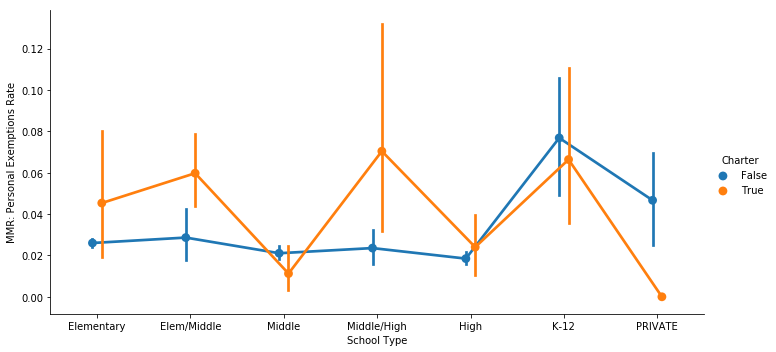

In [42]:
x_order = ['Elementary', 'Elem/Middle', 'Middle', 'Middle/High', 'High', 'K-12', 'PRIVATE']
sb.catplot(x='School Type',y='MMR: Personal Exemptions Rate',data=joined_df,
           kind='point',aspect=2,order=x_order,hue='Charter',dodge=.1)

There appear to be some significant differences in the rates of personal exemptions for charter schools compared to non-charter schools.

## Exercise 1

Write a groupby-aggregation to compute the average "Up to Date Rates" for each "School District" for these columns:
* "Average Up to Date Rate"
* "HepB: Up to Date Rate"
* "Dtap: Up to Date Rate"
* "Polio: Up to Date Rate"
* "MMR: Up to Date Rate"
* "Varicella: Up to Date Rate"
* "Tdap: Up to Date"

Keep in mind these 
* What is the groupby value?
* What is the aggregation function?

Save the aggregated DataFrame as `immunizations_gb_sd_agg`.

In [45]:
immunizations_gb_sd_agg = immunizations_df.groupby('School District').agg({"Average Up to Date Rate":np.mean})
immunizations_gb_sd_agg.head()

,Average Up to Date Rate
School District,
ACADEMY 20,0.881934
ADAMS 12 FIVE STAR SCHOOLS,0.965154
ADAMS COUNTY 14,0.979000
ADAMS-ARAPAHOE 28J,0.940381
AGUILAR REORGANIZED 6,0.928700


Sort the values in `immunizations_gb_sd_agg` by "MMR: Up to Date Rate". Which school districts have the lowest rates of MMR vaccination? The highest rates?

In [46]:
immunizations_gb_sd_agg.sort_values('Average Up to Date Rate')

,Average Up to Date Rate
School District,
MOFFAT 2,0.430150
OURAY R-1,0.733100
HINSDALE COUNTY RE 1,0.745600
HOLYOKE RE-1J,0.755900
BUENA VISTA R-31,0.760200
OTIS R-3,0.763800
TELLURIDE R-1,0.792600
SALIDA R-32,0.795780
PAWNEE RE-12,0.803700


## Exercise 2

Write a groupby-aggregation on `joined_df` using `exemptions_agg_d` but grouping by "School Type" and "Setting".

Which types of schools in which settings have the highest exemption rates?